<a href="https://colab.research.google.com/github/NOUTAILAA/ODIR-5KK/blob/main/ODIR_5K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================
# 1. Imports
# ============================================================
import os
import numpy as np
import pandas as pd
from PIL import Image

import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models

from google.colab import files
import matplotlib.pyplot as plt

# ============================================================
# 2. Config générale
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)

img_size = 224
batch_size = 16
num_epochs = 10
save_path = "odir_resnet18_multimodal_age_sex.pth"

label_names = ["N","D","G","C","A","H","M","O"]




Device utilisé : cpu


In [2]:
# ============================================================
# 3. Téléchargement et préparation du dataset ODIR-5K
# ============================================================
print("📥 Téléchargement du dataset ODIR-5K...")
path = kagglehub.dataset_download("andrewmvd/ocular-disease-recognition-odir5k")
print("Dataset root:", path)

root = os.path.join(path, "ODIR-5K", "ODIR-5K")
train_img_dir = os.path.join(root, "Training Images")
test_img_dir  = os.path.join(root, "Testing Images")
excel_path    = os.path.join(root, "data.xlsx")

print("Train path:", train_img_dir)
print("Excel path:", excel_path)

df = pd.read_excel(excel_path)
print("Colonnes du fichier Excel :")
print(df.columns)



📥 Téléchargement du dataset ODIR-5K...
Using Colab cache for faster access to the 'ocular-disease-recognition-odir5k' dataset.
Dataset root: /kaggle/input/ocular-disease-recognition-odir5k
Train path: /kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images
Excel path: /kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/data.xlsx
Colonnes du fichier Excel :
Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O'],
      dtype='object')


In [3]:
# ============================================================
# 4. Construction de df_img (une ligne = une image)
#    + ajout de l'âge & du sexe
# ============================================================
records = []

for _, row in df.iterrows():
    for side, col in [("left", "Left-Fundus"), ("right", "Right-Fundus")]:
        img_name = row[col]
        if pd.isna(img_name):
            continue

        img_path = os.path.join(train_img_dir, img_name)

        # Sécurité : on vérifie que le fichier existe
        if not os.path.exists(img_path):
            print("❌ Fichier introuvable:", img_path)
            continue

        records.append({
            "img_path": img_path,
            "side": side,
            "age": row["Patient Age"],
            "sex": row["Patient Sex"],
            "N": row["N"],
            "D": row["D"],
            "G": row["G"],
            "C": row["C"],
            "A": row["A"],
            "H": row["H"],
            "M": row["M"],
            "O": row["O"],
        })

df_img = pd.DataFrame(records)
print(len(df_img), "images au total avant nettoyage")

# ------------------------------------------------------------
# Encodage du sexe et normalisation de l'âge (MULTIMODAL)
# ------------------------------------------------------------
# Encodage du sexe : M → 0, F → 1
df_img["sex"] = df_img["sex"].map({"M": 0, "F": 1})

# Gestion des valeurs manquantes éventuelles
df_img["sex"] = df_img["sex"].fillna(0)  # par défaut 0 si inconnu
df_img["age"] = df_img["age"].fillna(df_img["age"].median())

# Normalisation de l'âge dans [0,1]
df_img["age"] = df_img["age"] / df_img["age"].max()

print("\nAperçu âge / sexe encodés :")
print(df_img[["age", "sex"]].head())


7000 images au total avant nettoyage

Aperçu âge / sexe encodés :
        age  sex
0  0.758242  0.0
1  0.758242  0.0
2  0.626374  0.0
3  0.626374  0.0
4  0.461538  0.0


In [4]:
# ============================================================
# 5. Transforms & Dataset
# ============================================================
train_tfms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

val_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

class ODIRDataset(Dataset):
    """
    Dataset multimodal : image + métadonnées (âge, sexe) + labels multi-label
    """
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["img_path"]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Labels multi-label (8 pathologies)
        labels = torch.tensor(
            row[["N","D","G","C","A","H","M","O"]].values.astype("float32")
        )

        # Métadonnées : âge normalisé + sexe encodé
        age = torch.tensor(row["age"], dtype=torch.float32)
        sex = torch.tensor(row["sex"], dtype=torch.float32)
        meta = torch.stack([age, sex])  # shape (2,)

        return image, meta, labels




In [5]:
# ============================================================
# 6. Split train / val & DataLoaders
# ============================================================
train_df, val_df = train_test_split(
    df_img,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

train_dataset = ODIRDataset(train_df, transform=train_tfms)
val_dataset   = ODIRDataset(val_df,   transform=val_tfms)

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size,
                          shuffle=False, num_workers=2)

print("Taille train :", len(train_dataset))
print("Taille val   :", len(val_dataset))



Taille train : 5600
Taille val   : 1400


In [6]:
# ============================================================
# 7. Modèle multimodal (CNN image + MLP âge/sex)
# ============================================================
class MultimodalResNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Backbone image : ResNet18 pré-entraîné
        self.cnn = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        num_ftrs = self.cnn.fc.in_features
        self.cnn.fc = nn.Identity()   # on enlève la tête de classification

        # Petit MLP pour (âge, sexe)
        self.meta_fc = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU()
        )

        # Tête finale : concat(img_feat, meta_feat) -> 8 labels
        self.classifier = nn.Linear(num_ftrs + 16, 8)

    def forward(self, image, meta):
        img_feat = self.cnn(image)            # (B, num_ftrs)
        meta_feat = self.meta_fc(meta)        # (B, 16)
        x = torch.cat([img_feat, meta_feat], dim=1)
        logits = self.classifier(x)           # (B, 8)
        return logits

model = MultimodalResNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)




Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


In [8]:
# ============================================================
# 8. Boucles d'entraînement / validation
# ============================================================
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for images, meta, labels in loader:
        images = images.to(device)
        meta   = meta.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, meta)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)


@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0

    for images, meta, labels in loader:
        images = images.to(device)
        meta   = meta.to(device)
        labels = labels.to(device)

        outputs = model(images, meta)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)

# ------------------------------------------------------------
# Lancement de l'entraînement
# ------------------------------------------------------------
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss   = eval_one_epoch(model,   val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs} - train_loss={train_loss:.4f}  val_loss={val_loss:.4f}")



Epoch 1/10 - train_loss=0.3208  val_loss=0.2952
Epoch 2/10 - train_loss=0.2831  val_loss=0.2874
Epoch 3/10 - train_loss=0.2684  val_loss=0.2770
Epoch 4/10 - train_loss=0.2553  val_loss=0.2760
Epoch 5/10 - train_loss=0.2448  val_loss=0.2766
Epoch 6/10 - train_loss=0.2303  val_loss=0.2855
Epoch 7/10 - train_loss=0.2167  val_loss=0.3003
Epoch 8/10 - train_loss=0.2015  val_loss=0.3011
Epoch 9/10 - train_loss=0.1905  val_loss=0.3142
Epoch 10/10 - train_loss=0.1654  val_loss=0.3144


In [9]:

# Sauvegarde des poids
torch.save(model.state_dict(), save_path)
print("✅ Modèle sauvegardé dans :", save_path)


✅ Modèle sauvegardé dans : odir_resnet18_multimodal_age_sex.pth


In [10]:
# ============================================================
# 9. Évaluation simple : accuracy & AUC par label
# ============================================================
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for images, meta, labels in val_loader:
        images = images.to(device)
        meta   = meta.to(device)

        logits = model(images, meta)
        probs = torch.sigmoid(logits).cpu().numpy()

        all_probs.append(probs)
        all_labels.append(labels.numpy())

all_probs = np.concatenate(all_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print("Shape probs :", all_probs.shape)
print("Shape labels:", all_labels.shape)

preds = (all_probs > 0.5).astype(np.float32)

print("\n🔹 Accuracy par pathologie :")
for i, name in enumerate(label_names):
    acc = (preds[:, i] == all_labels[:, i]).mean()
    print(f"{name} - accuracy: {acc:.3f}")

print("\n🔹 AUC par pathologie :")
for i, name in enumerate(label_names):
    y_true = all_labels[:, i]
    y_score = all_probs[:, i]

    if len(np.unique(y_true)) < 2:
        print(f"{name} - AUC: impossible (une seule classe présente)")
        continue

    auc = roc_auc_score(y_true, y_score)
    print(f"{name} - AUC: {auc:.3f}")

Shape probs : (1400, 8)
Shape labels: (1400, 8)

🔹 Accuracy par pathologie :
N - accuracy: 0.695
D - accuracy: 0.711
G - accuracy: 0.947
C - accuracy: 0.965
A - accuracy: 0.965
H - accuracy: 0.966
M - accuracy: 0.984
O - accuracy: 0.699

🔹 AUC par pathologie :
N - AUC: 0.725
D - AUC: 0.739
G - AUC: 0.878
C - AUC: 0.938
A - AUC: 0.813
H - AUC: 0.750
M - AUC: 0.945
O - AUC: 0.691


In [11]:
# ============================================================
# 10. Prédiction sur une image de val_df (avec âge & sexe)
# ============================================================
row = val_df.iloc[0]
img_path = row["img_path"]
print("\n🖼️ Image de validation :", img_path)

img = Image.open(img_path).convert("RGB")

input_tensor = val_tfms(img).unsqueeze(0).to(device)

# Métadonnées associées à cette image
age_tensor = torch.tensor([[row["age"]]], dtype=torch.float32, device=device)  # shape (1,1)
sex_tensor = torch.tensor([[row["sex"]]], dtype=torch.float32, device=device)  # shape (1,1)
meta_tensor = torch.cat([age_tensor, sex_tensor], dim=1)  # shape (1,2)

model.eval()
with torch.no_grad():
    logits = model(input_tensor, meta_tensor)
    probs = torch.sigmoid(logits).cpu().numpy()[0]
    preds = (probs > 0.5).astype(int)

print("\nLabels vrais :")
for name in label_names:
    print(f"  {name}: {row[name]}")

print("\nPrédictions du modèle :")
for name, p, b in zip(label_names, probs, preds):
    print(f"  {name}: p={p:.3f}  ->  pred={b}")





🖼️ Image de validation : /kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/4400_left.jpg

Labels vrais :
  N: 0
  D: 1
  G: 0
  C: 0
  A: 0
  H: 0
  M: 0
  O: 0

Prédictions du modèle :
  N: p=0.234  ->  pred=0
  D: p=0.292  ->  pred=0
  G: p=0.011  ->  pred=0
  C: p=0.008  ->  pred=0
  A: p=0.023  ->  pred=0
  H: p=0.010  ->  pred=0
  M: p=0.000  ->  pred=0
  O: p=0.716  ->  pred=1



📤 Upload d'une image externe...


Saving fundusimage.png to fundusimage (1).png
Image uploadée : fundusimage (1).png


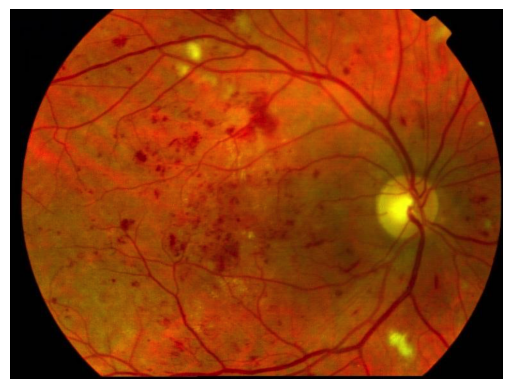

👉 Entrez l'âge du patient (en années) : 60
👉 Entrez le sexe du patient (M ou F) : M

🔍 Résultats du modèle sur l'image uploadée :

N: p=0.000 → pred=0
D: p=0.915 → pred=1
G: p=0.000 → pred=0
C: p=0.000 → pred=0
A: p=0.003 → pred=0
H: p=0.000 → pred=0
M: p=0.000 → pred=0
O: p=0.000 → pred=0


In [13]:
# ============================================================
# 11. Prédiction sur une image uploadée manuellement
#     (âge & sexe saisis par l'utilisateur)
# ============================================================
print("\n📤 Upload d'une image externe...")
uploaded = files.upload()

# Récupérer le nom du fichier uploadé
external_path = list(uploaded.keys())[0]
print("Image uploadée :", external_path)

# Charger et afficher l'image
img_ext = Image.open(external_path).convert("RGB")

plt.imshow(img_ext)
plt.axis("off")
plt.show()

# Préparer l'image pour le modèle
input_tensor = val_tfms(img_ext).unsqueeze(0).to(device)

# ===============================
# 🔹 Saisie manuelle âge & sexe
# ===============================
# age_raw = âge réel (en années)
# sex_raw = 0 (M) ou 1 (F)

age_raw = float(input("👉 Entrez l'âge du patient (en années) : "))

sex_input = input("👉 Entrez le sexe du patient (M ou F) : ").strip().upper()
if sex_input == "M":
    sex_raw = 0
elif sex_input == "F":
    sex_raw = 1
else:
    raise ValueError("Sexe invalide. Entrez 'M' ou 'F'.")

# Normaliser l'âge avec le même max que pour df_img
age_norm = age_raw / df_img["age"].max()

age_tensor = torch.tensor([[age_norm]], dtype=torch.float32, device=device)
sex_tensor = torch.tensor([[sex_raw]], dtype=torch.float32, device=device)
meta_tensor = torch.cat([age_tensor, sex_tensor], dim=1)  # shape (1, 2)

# Prédiction
model.eval()
with torch.no_grad():
    logits = model(input_tensor, meta_tensor)
    probs = torch.sigmoid(logits).cpu().numpy()[0]
    preds = (probs > 0.5).astype(int)

print("\n🔍 Résultats du modèle sur l'image uploadée :\n")
for name, p, b in zip(label_names, probs, preds):
    print(f"{name}: p={p:.3f} → pred={b}")


In [14]:
from google.colab import files

files.download("odir_resnet18_multimodal_age_sex.pth")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>